In [1]:
# Requires Presto's python bindings for Pgplot display

%config InlineBackend.figure_format = 'retina'
import sys
import glob
import os
import numpy as np
import scipy.interpolate
import scipy.constants as c
import matplotlib.cm as cm
import pylab as plt
import presto.psr_utils as pu
from presto.ppgplot import *
from presto.Pgplot import *
import pgplot_palette as pp

DEG2RAD = np.pi/180.



/usr/local/lib/python3.10/dist-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [46]:
class Beam_profiles:
    def __init__(self, longitudes, whichbeam='mainpulse', backend='BON', verbose=False):

        self.f = None

        #self.nbins = nbins # Number of bins in the constructed profile
        self.whichbeam = whichbeam
        self.verbose = verbose
        self.backend = backend
        self.phases = longitudes ## In deg
        self.dphase = self.phases[1] - self.phases[0]  
        self.nbins = len(self.phases)

        # Read all profiles (already scaled with flux)
        if backend=='BON':
            fns = '/data/1906/1906-ref-data/5-gaussian/%s/5[3-5]*.gaussian'%self.whichbeam
        elif backend=='PUPPI':
            fns = '/data/1906/1906-ref-data/5-gaussian/%s/5[6-8]*.gaussian'%self.whichbeam
        else:
            fns = '/data/1906/1906-ref-data/5-gaussian/%s/51*.gaussian*'%self.whichbeam
        self.mjd_profs, self.profiles = self.construct_profiles(fns)
        #print self.mjd_profs

    def get_epochs(self):
        return self.mjd_profs
    
    def get_profiles(self):
        return self.profiles
        
    def get_min_MJD(self):
        return int(np.min(self.mjd_profs))+1 # Round up to superior MJD to avoid extrapolation

    def get_max_MJD(self):
        return int(np.max(self.mjd_profs))

    def prof_from_gaussians(self, x, center, height, sigma):
        """Form gaussian synthetic profile
        Input: 
            x: Numpy array
            center:
            height:
            sigma
        Return:
            profile (Numpy array)
        """
        if self.whichbeam=='mainpulse':
            center -= 90
        if self.whichbeam=='interpulse':
            center -= 90
        if not isinstance(center, np.ndarray):
            return height * np.exp(-np.square(x-center)/(2*np.square(sigma)))
        prof = np.zeros(x.size)
        for c, h, s in zip(center, height, sigma):
            prof += h * np.exp(-np.square(x-c)/(2*np.square(s)))
        return prof

    def get_profile_from_file(self, fn):
        """Read a gaussian file as:
        #### Gaussian Template #####
        MJD: 54416.91733955012
        Components: 3
        0 15.047137 0.114747 3.254594
        1 17.145561 0.608896 0.458382
        2 15.644906 0.747117 1.072030
        """

        # Open file
        pf = open(fn, 'r')
        lines = pf.readlines()
        pf.close()

        # Read params
        mjd = float(lines[1].split()[1])
        ncomp = lines[2].split()[1]

        # Read gaussians
        #print(fn)
        icomp, center, height, sigma = np.loadtxt(fn, skiprows=3, unpack=True)

        # Form synthetic profile
        prof = self.prof_from_gaussians(self.phases, center, height, sigma)
        
        if self.whichbeam=='interpulse' and int(mjd)==57890:
            print ("Correcting MJD 57890")
            prof*=1.25

        return prof, mjd

    def construct_profiles(self, fns):
        """Read all input templates
        Input: 
            fns: string of
        """
        # Get gaussians
        files = glob.glob(fns)
        files.sort()
        #print("GD ", fns, files)

        # Use first profile to concatenate the following profs
        profiles, mjd_profs = self.get_profile_from_file(files[0])
        ##profiles /= np.max(profiles)
        profiles = np.array([profiles])

        for ii,fn in enumerate(files[1:]):
            prof, mjd_prof = self.get_profile_from_file(fn)
            if self.verbose:
                plt.plot(prof, label=os.path.split(fn)[-1])

            profiles = np.concatenate((profiles, np.array([prof])),axis=0)
            mjd_profs = np.append(mjd_profs, mjd_prof)

        if self.verbose:
            #plt.legend()
            plt.show()

        # Now sort out all the profiles
        ids = np.argsort(mjd_profs)
        mjd_profs = np.take(mjd_profs, ids)
        profiles = np.take(profiles, ids, axis=0)
        return mjd_profs, profiles

    def construct_beam_map(self):

        # Smooth and interpolate profiles
        if self.whichbeam=='mainpulse' and self.backend=='BON':
            map = scipy.interpolate.RectBivariateSpline(self.mjd_profs, self.phases, self.profiles, ky=2, kx=1, s=0) # ky = 5
        elif self.whichbeam=='mainpulse' and self.backend=='PUPPI':
            map = scipy.interpolate.RectBivariateSpline(self.mjd_profs, self.phases, self.profiles, ky=1, kx=1, s=0) # ky =4 
        elif self.whichbeam=='interpulse' and self.backend=='PUPPI':
            map = scipy.interpolate.RectBivariateSpline(self.mjd_profs, self.phases, self.profiles, ky=2, kx=1, s=0)
        else:
            #map = scipy.interpolate.RectBivariateSpline(self.mjd_profs, self.phases, self.profiles,  s=100)
            map = scipy.interpolate.RectBivariateSpline(self.mjd_profs, self.phases, self.profiles, ky=3, kx=1, s=0)

        #print self.get_min_MJD(), self.get_max_MJD(), np.max(self.profiles)
        mjds = np.arange(self.get_min_MJD(), self.get_max_MJD())
        first = 1
        for mjd in mjds:
            mjd_ar = np.repeat(np.array([mjd]), self.nbins)
            val = map.ev(mjd_ar, self.phases)

            """
            mdiff = 99999
            if (0 and mjd%30==0):
                #print "greg: MJD ",mjd, np.max(val)
                if self.f:
                    print self.f[mjd]
                for iprof,m in enumerate(self.mjd_profs):
                    diff = np.abs(mjd - m)
                    if diff < mdiff:
                        prof_id = iprof
                        mdiff = diff
                plt.plot(self.phases,self.profiles[prof_id])
                plt.plot(self.phases,val)
                plt.show()
            """


            if first:
                beam = np.array([val])
                first = 0
            else:
                beam = np.concatenate((beam, np.array([val])), axis=0)
        return mjds, beam



In [49]:

class Beam:
    def __init__(self, prec_rate, alpha, delta, inc, phase0, mjd0, period=0.144):
        self.prec_rate = prec_rate * DEG2RAD /365.25
        self.alpha = alpha * DEG2RAD
        self.delta = delta * DEG2RAD
        self.inc = inc * DEG2RAD
        self.phase0 = phase0 * DEG2RAD
        self.mjd0 = mjd0
        self.period = period # Pulsar rotationnal period in s
        self.radius = 10000 # Pulsar radius in m
        self.mjd_step = 1

    def get_profiles_epochs(self):
        return self.beam_profiles.get_epochs()
    
    def get_profiles(self):
        return self.beam_profiles.get_profiles()
        
    def get_beta(self, mjd):
        """Compute Beta:
        Input: 
            mjd: Date (MJD)
        Return:
            beta (radians)
        """
        # compute beta
        phase = self.prec_rate * (mjd-self.mjd0) + self.phase0
        Lambda = np.arccos(np.cos(self.delta)*np.cos(self.inc)-np.sin(self.delta)*np.sin(self.inc)*np.cos(phase))
        beta = (np.pi - self.alpha - Lambda)
        return beta
    
    def get_theory_rem(self, beta):
        """Computes the theoretical emission height given Eq. 3.29 from the pulsar handbook
        Input: 
            beta: Impact parameter or opening angle (radians)
        Return:
            Emission height (in m)
        """       
        return beta/DEG2RAD*beta/DEG2RAD / 1.24**2 * self.period *10 * 1000
    
    def get_modeled_rem(self, beta):
        """Computes the modeled emission height given Michael's equation
        Input: 
            beta: Impact parameter or opening angle (radians)
        Return:
            Emission height (in m)
        """
        f = (-0.743*beta)*DEG2RAD
        g = 2.95e-5 + 5.28e-7*beta**2
        return f*f/g * 1000
    
    def get_aberr_em(self,verbose=False):
        if self.whichbeam=='mainpulse':
            fn = "/data/1906/beam/mainpulse/mainpulse.log"
        else:
            fn = "/data/1906/beam/interpulse/interpulse.log"
            
        mjd, phi0, beta = np.loadtxt(fn, usecols=(0,3,4), unpack=True, dtype=float)
        
        phi0 = np.where(phi0<0, phi0, 0)
        rem = -1*phi0/360. * c.c * self.period /4./1000.
        rem *= 1000
        
        z = np.polyfit(mjd,rem,2)
        self.em_h = np.poly1d(z)
        x = np.arange(mjd.min(),mjd.max(),10)
        if verbose:
            plt.plot(mjd,rem,'o')
            plt.xlabel("MJD")
            plt.ylabel("Emission height (m)")
            plt.plot(x,self.em_h(x))
            plt.savefig("emission_height_%s.eps"%self.whichbeam, bbox_inches='tight')
        
            # Overplot the theoretical Em h.
            #plt.plot(mjd, self.get_theory_rem(beta), color='grey')
            plt.show()

    def get_psi(self, mjd):
        """Get absolute position angle
        Input:
            mjd: Date (MJD)
        Return:
            psi (radians)
        """
        # Compute Lambda
        phase = self.prec_rate * (mjd-self.mjd0) + self.phase0
        Lambda = np.arccos(np.cos(self.delta)*np.cos(self.inc)-np.sin(self.delta)*np.sin(self.inc)*np.cos(phase))
        # compute psi
        cospsi = np.sin(self.delta)*np.sin(phase)/np.sin(Lambda)
        sinpsi = (np.cos(Lambda) * np.cos(self.inc) - np.cos(self.delta)) / np.sin(self.inc) / np.sin(Lambda)
        psi = np.arctan2(sinpsi, cospsi)
        return psi

    def val2ind(self, x, y, bmax):
        indx = np.where ((np.abs(x)<bmax) & (np.abs(y)<bmax), ((x+bmax)/(2.*bmax)*self.dim1).astype(int), 0)
        indy = np.where ((np.abs(x)<bmax) & (np.abs(y)<bmax), ((y+bmax)/(2.*bmax)*self.dim1).astype(int), 0)
        return indx, indy

    def makebeam(self, beam_extent=15, dim1=512, whichbeam='mainpulse', backend='BON', model='observed', verbose=False):
        
        self.dim1 = dim1
        self.beam_dim = (self.dim1, self.dim1)
        self.beam = np.zeros(self.beam_dim)
        self.counts = np.ones(self.beam_dim)
        self.whichbeam = whichbeam
        #if model=='footprint':
        #    self.get_aberr_em()
            
        if self.whichbeam=='mainpulse':
            if backend=='BON':longitudes = np.arange(-15, 3, 0.04)
            elif backend=='PUPPI':longitudes = np.arange(-25, 10, 0.04) 
            else: longitudes = np.arange(-30, 30, 0.02)
        else:
            longitudes = np.arange(-30, 30, 0.02)

        # Get interpolated beam profiles
        print ("Loading profiles")
        self.beam_profiles = Beam_profiles(longitudes, whichbeam=self.whichbeam, backend=backend, verbose=verbose)
        #print beam.get_min_MJD(), beam.get_max_MJD()
        mjds, beam_map = self.beam_profiles.construct_beam_map()
        print ("Profiles loaded")
        
        if verbose:
            print(whichbeam, backend)
            plt.imshow(beam_map)
            #plt.colorbar()
            plt.xlabel("Phase")
            plt.ylabel("MJD")
            plt.show()

        longitudes *= DEG2RAD

        for mjd, prof in zip(mjds,beam_map):

            # Compute beta
            beta = self.get_beta(mjd)
            
            # Map profile to the beam coordinates
            x, y = self.map_profile2beam(mjd, beta, longitudes, model=model)         

            indx, indy = self.val2ind(x,y,beam_extent)
                
            # Now do the mapping if needed
            slice2map = np.where((indx==0) & (indy==0), 0.0, prof)
            counts = np.where((indx==0) & (indy==0), 0, 1)

            self.beam[indx,indy] += slice2map
            self.counts[indx,indy] += counts
            
        self.beam /= self.counts     
        #self.beam = np.where(self.beam<.1*np.max(self.beam), 0., self.beam ) # Clean below the 10% threshold
        return self.beam

    
    def get_az_la(self, beta, phi):
            xsi = self.alpha+beta
            
            # Magnetic azimuth
            Phi = np.arctan2(np.sin(xsi)*np.sin(phi),(np.sin(self.alpha)*np.cos(xsi)-np.cos(self.alpha)*np.sin(xsi)*np.cos(phi)))
            
            # Magnetic colatitude
            Gamma = np.arccos(np.cos(self.alpha)*np.cos(xsi)+np.sin(self.alpha)*np.sin(xsi)*np.cos(phi))
            
            a1 = np.cos(Gamma)*np.sqrt(8+np.cos(Gamma)*np.cos(Gamma))
            Theta = 1/2.* np.arccos((a1 - np.sin(Gamma)*np.sin(Gamma))/3.)
  
            return Phi, Theta

    def map_profile2beam(self, mjd, beta, phi, model='observed'):
        #print mjd, beta/DEG2RAD, phi/DEG2RAD, model
        if model=='observed':
            R = np.arccos(np.cos(self.alpha + beta) * np.cos(self.alpha) + np.sin(self.alpha+beta) * np.sin(self.alpha) * np.cos(phi))
            # Fix round off errors
            R = np.around(R, decimals=6)
        
            cosgamma = np.where(R == 0.0, 0.0, (np.cos(self.alpha+beta)-np.cos(self.alpha)*np.cos(R))/(np.sin(self.alpha)*np.sin(R)))
            cosgamma = np.where(self.alpha > 0.0, cosgamma, 0.0)
        
            # Fix round off errors
            cosgamma = np.around(cosgamma, decimals=5)
            gamma = np.arccos(cosgamma)        
            x = R * np.sin(gamma) / DEG2RAD
            x = np.where(phi>0.0, -x, x)
            y = -R * cosgamma / DEG2RAD
            
        if model=='footprint':
            # Get azimuth and colatitude magnetic angles
            Phi, Theta = self.get_az_la(beta, phi)

            # Recompute for the magnetic meridian (phi=0)
            Phi0, Theta0 = self.get_az_la(beta, 0)
            
            # Get the emission height at the magnetic meridian
            # Option 1: Assumes Eq. 3.29 from handbook
            #rem0 = self.get_theory_rem(beta)
            # Option 2: Estimate it from BCW aberration - Need to run self.get !
            #rem0 = self.em_h(mjd)
            # Option 3: Use the modeled emission height
            rem0 = self.get_modeled_rem(beta/DEG2RAD)
            #print rem0
            
            # Curvature radius of field line
            Rho0 = (10+6*np.cos(2*Theta0))**1.5/(12*(3+np.cos(2*Theta0))*np.sin(Theta0)) * rem0
            
            # Emission height
            rem = (12*(3+np.cos(2*Theta))*np.sin(Theta))/(10+6*np.cos(2*Theta))**1.5 * Rho0 ## TBD
            
            sem = np.sqrt(np.power(self.radius,3)/rem) * np.sin(Theta)
            
            x = sem * np.cos(Phi)
            y = sem * np.sin(Phi)
            
            # For map rotation, to match the one of sky-projection
            y = -sem * np.cos(Phi)
            x = -sem * np.sin(Phi)
  
        return x,y

    def add_LOS(self, mjd, model='observed'):
        """Compute a line of sight at a given MJD:
        Input: 
            mjd: Date (MJD)
        Return:
            array
        """
        longitudes = np.arange(-60., 60., 0.02) * DEG2RAD
        beta = self.get_beta(mjd)
        return self.map_profile2beam(mjd, beta, longitudes, model=model)
    
    
    def add_LOS_beta(self, beta):
        """Compute a line of sight for a given beta:
        Input: 
            beta: Impact parameter (deg)
        Return:
            array
        """
        longitudes = np.arange(-60., 60., 0.02) * DEG2RAD
        mjd = None
        return self.map_profile2beam(mjd, beta*DEG2RAD, longitudes)




Building MP Beam
Loading profiles


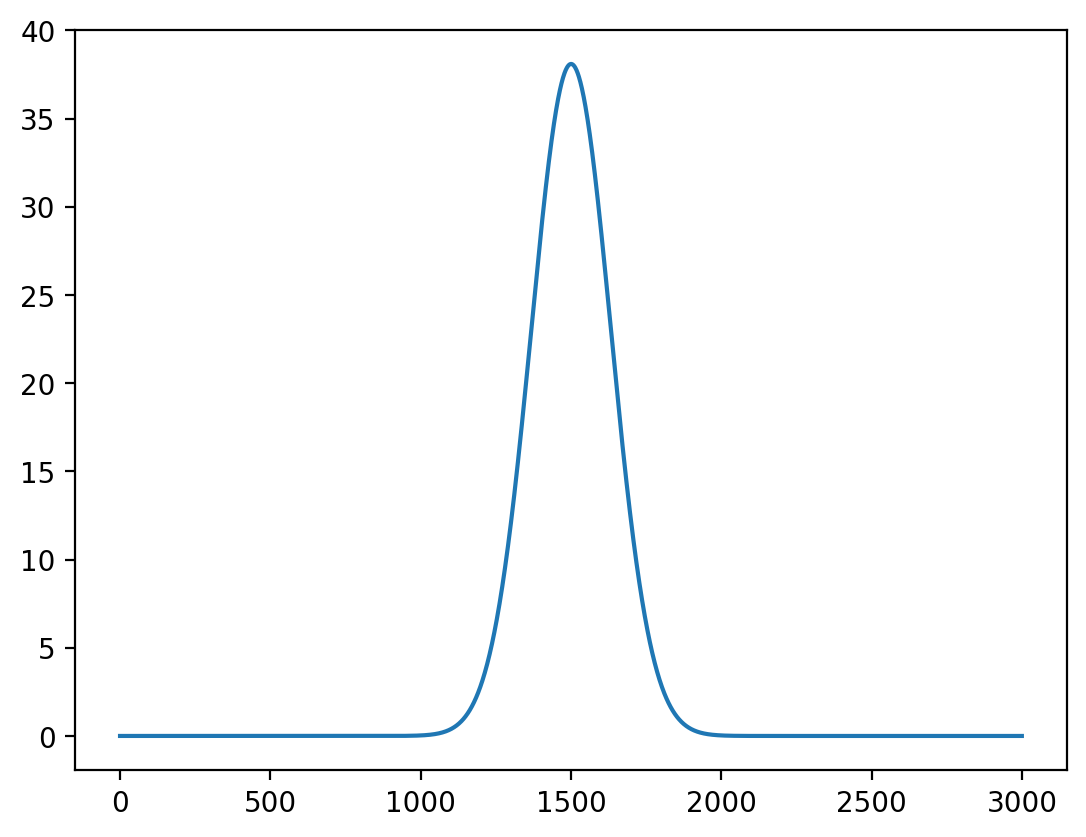

Profiles loaded
mainpulse PMPS


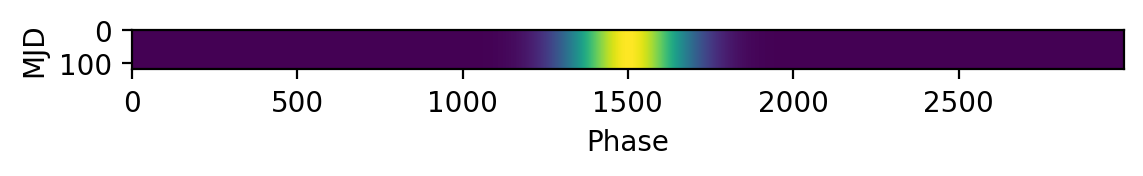

Loading profiles


/tmp/ipykernel_10699/3545684824.py:181: RuntimeWarning: invalid value encountered in arccos
  gamma = np.arccos(cosgamma)


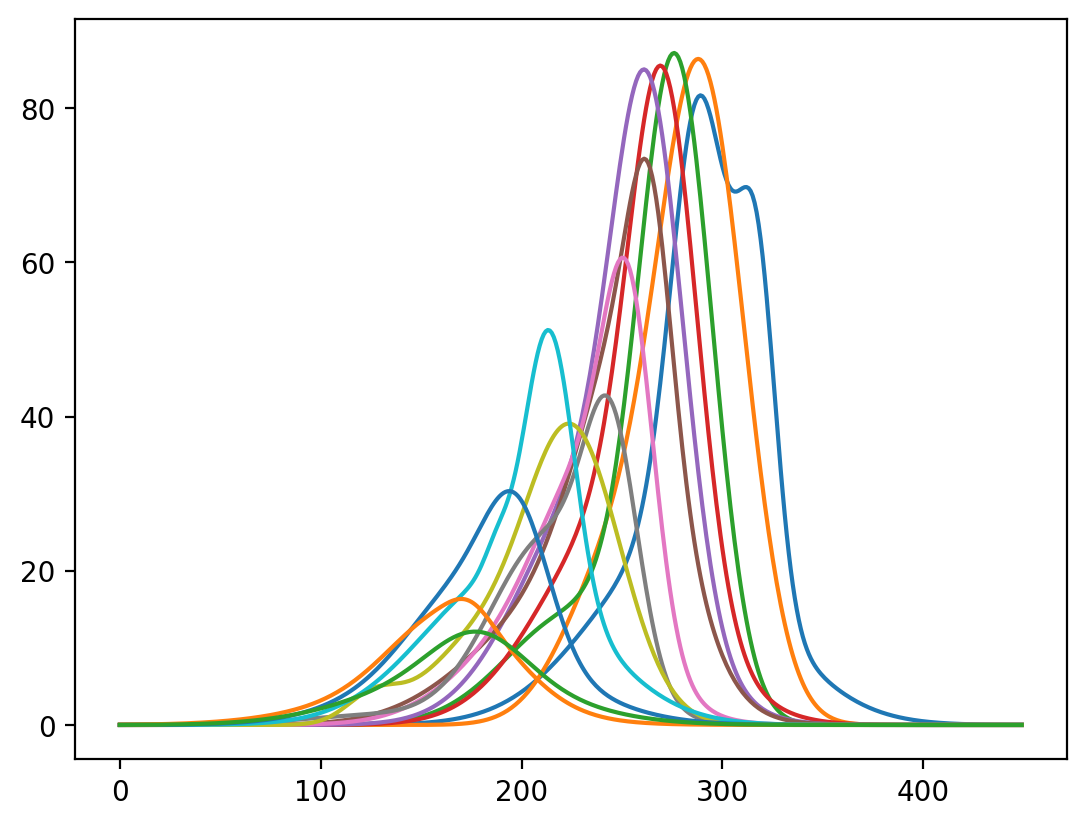

Profiles loaded
mainpulse BON


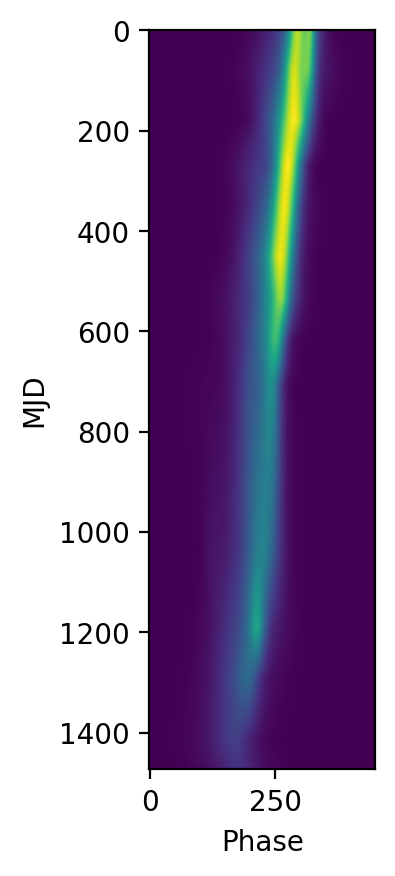

Loading profiles


/tmp/ipykernel_10699/3669136495.py:51: RuntimeWarning: divide by zero encountered in divide
  return height * np.exp(-np.square(x-center)/(2*np.square(sigma)))


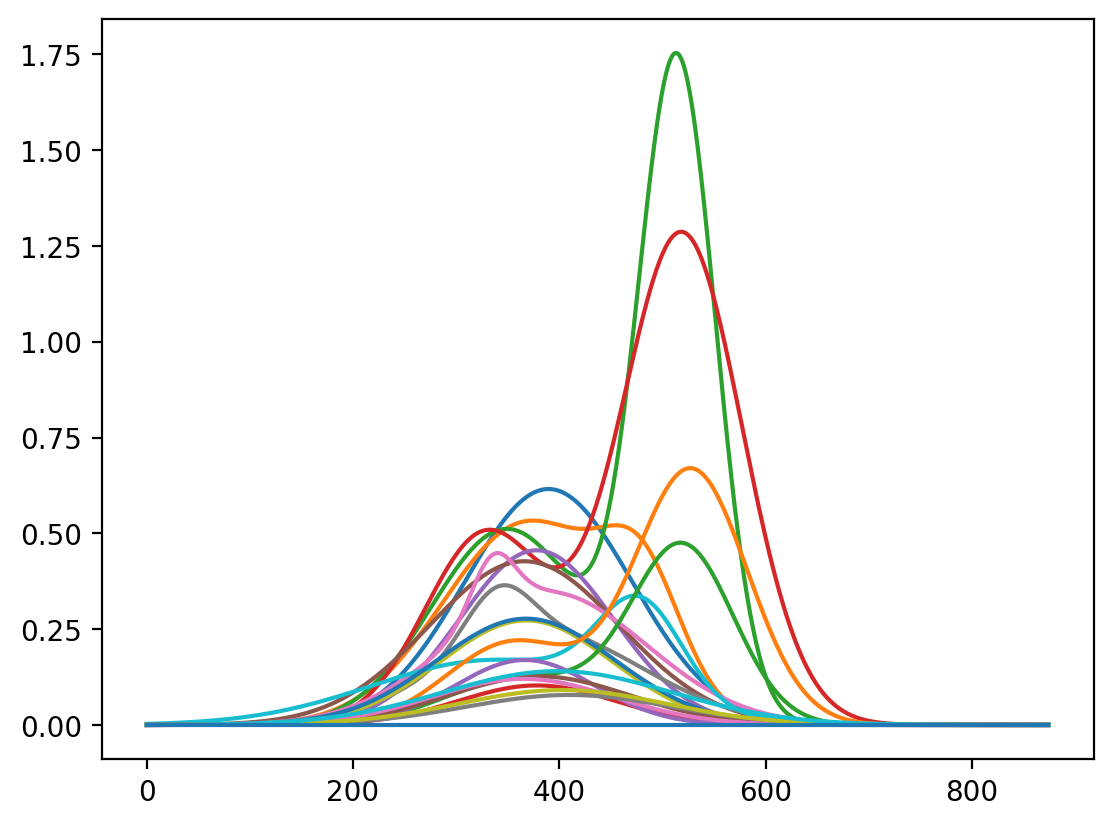

Profiles loaded
mainpulse PUPPI


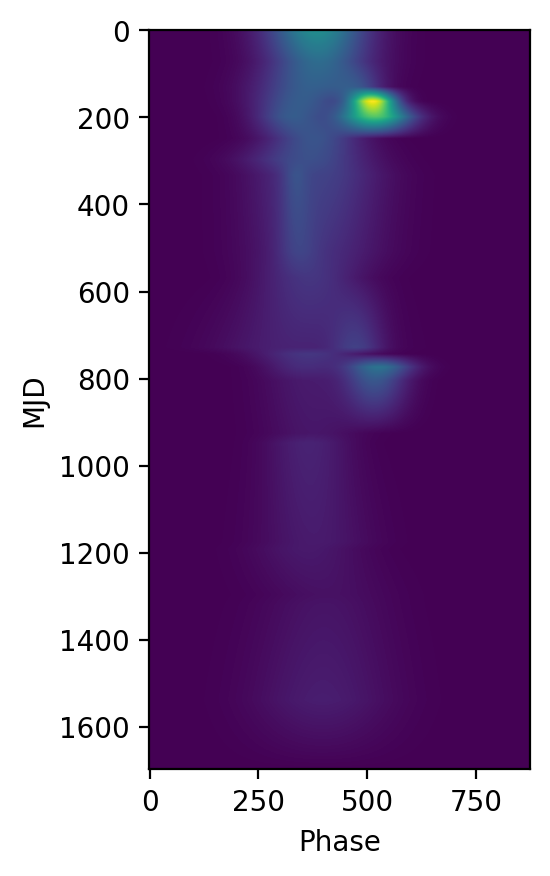

Building IP Beam
Loading profiles


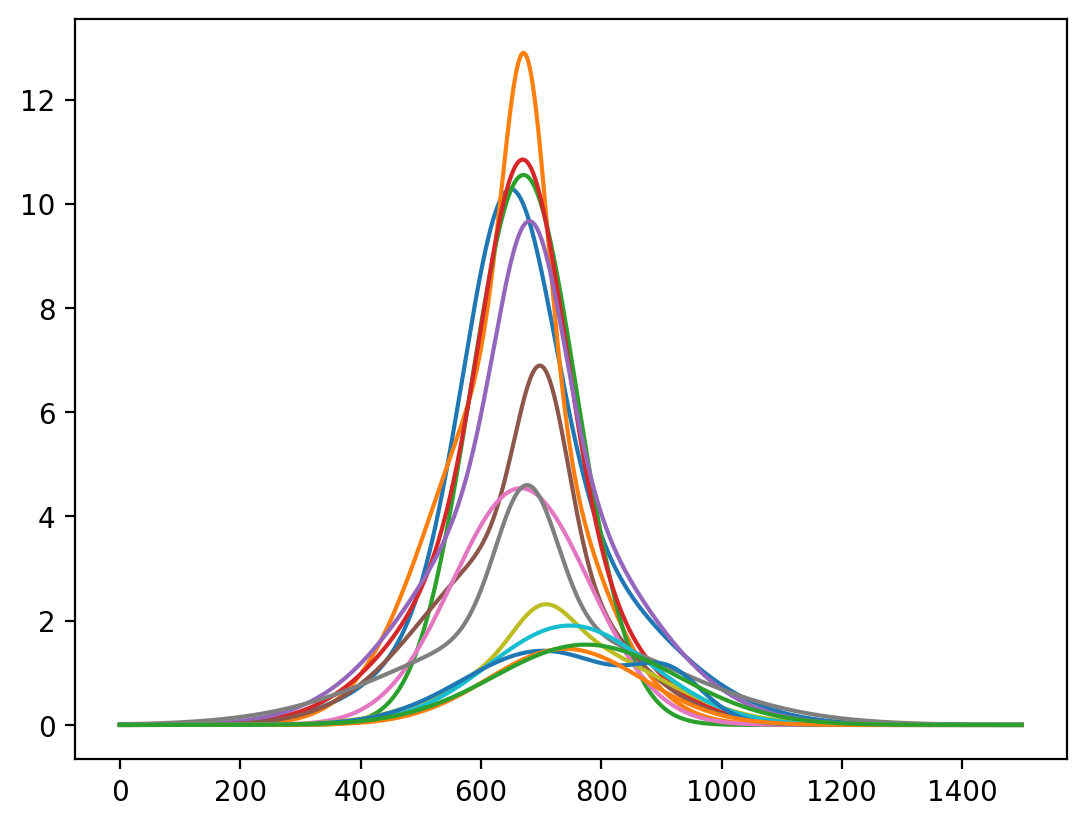

Profiles loaded
interpulse BON


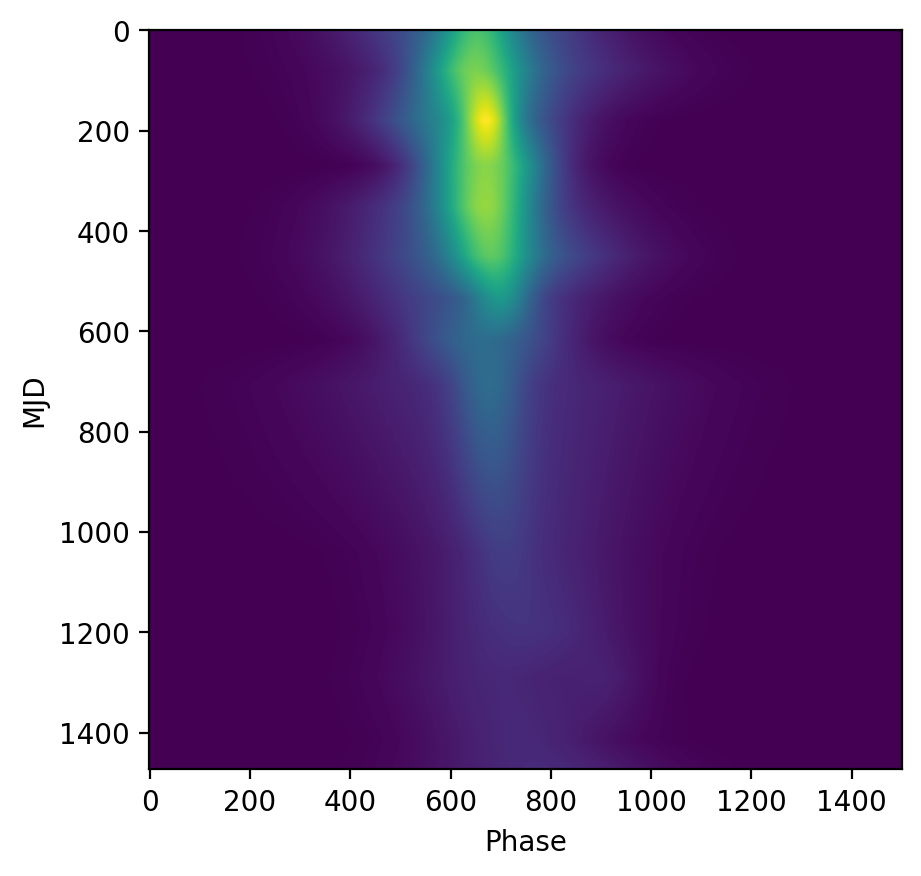

Loading profiles
Correcting MJD 57890


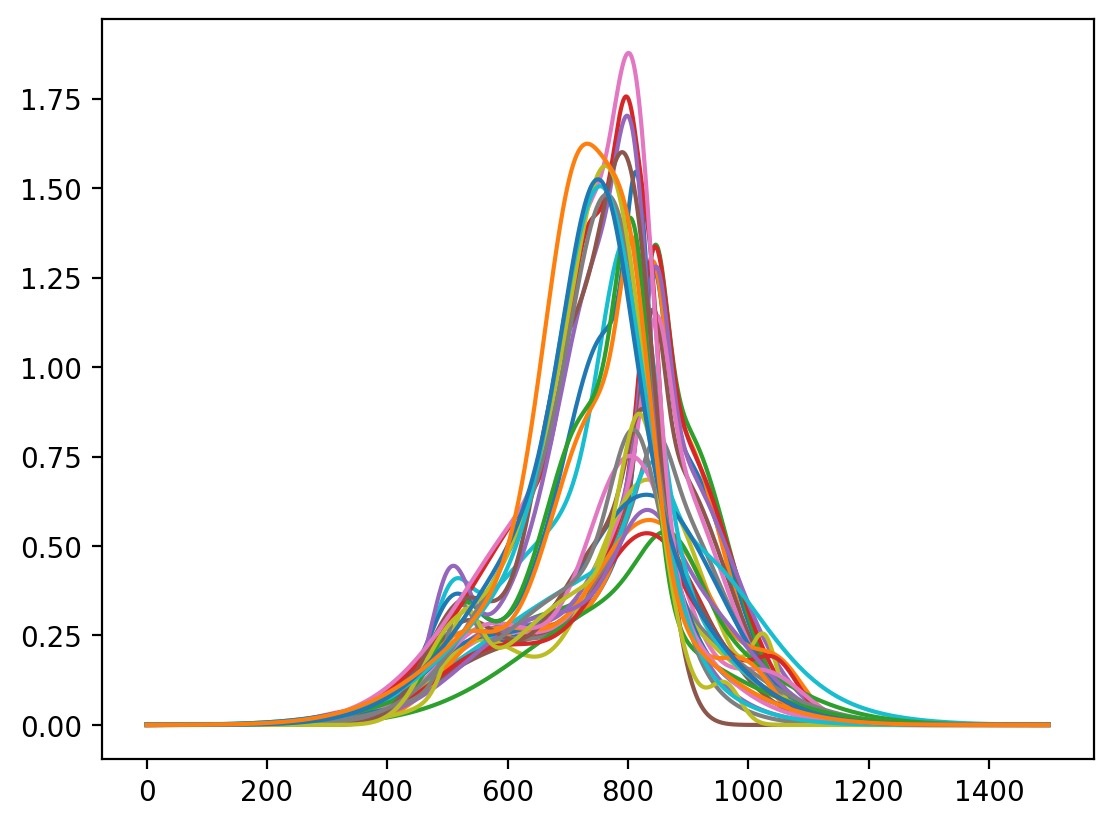

Profiles loaded
interpulse PUPPI


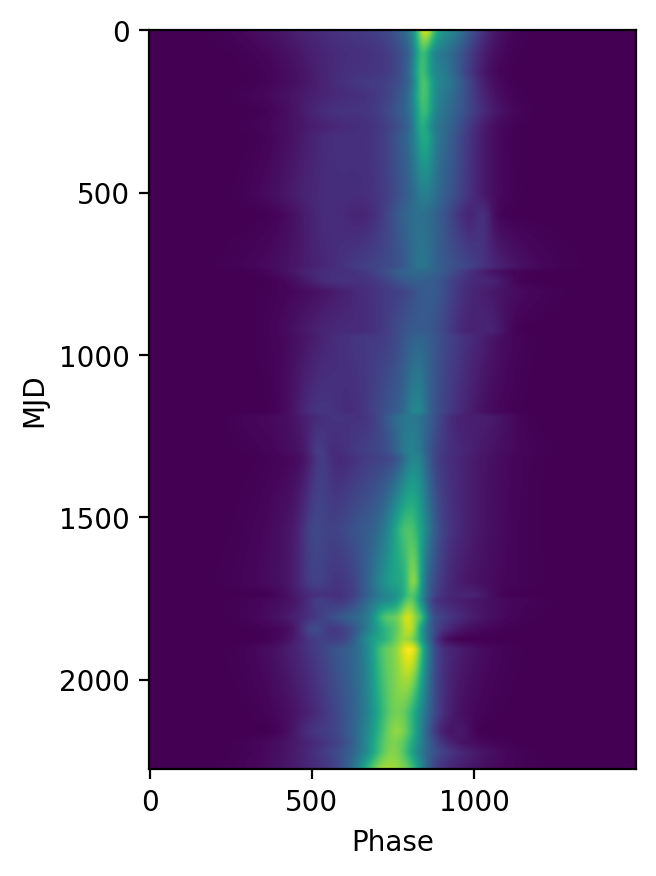

In [50]:
import p1906 
prec_rate = 2.237
delta = p1906.DELTA
inc = 43.7
phase0 = p1906.PHI0
mjd0 = 53572  

dim1 = 512 # Dimension of the array to plot

model='observed'
beam_extent = 27 ### Degrees
verb = True


print ("Building MP Beam")
whichbeam = 'mainpulse' 
alpha = p1906.ALPHA
beam_PMPS_mp = Beam(prec_rate, alpha, delta, inc, phase0, mjd0)
beam_BON_mp = Beam(prec_rate, alpha, delta, inc, phase0, mjd0)
beam_PUPPI_mp = Beam(prec_rate, alpha, delta, inc, phase0, mjd0)
beam_map_PMPS_MP = beam_BON_mp.makebeam(beam_extent=beam_extent, whichbeam=whichbeam, backend='PMPS', model=model,verbose=verb)
beam_map_BON_MP = beam_BON_mp.makebeam(beam_extent=beam_extent, whichbeam=whichbeam, model=model,verbose=verb)
beam_map_PUPPI_MP = beam_PUPPI_mp.makebeam(beam_extent=beam_extent, whichbeam=whichbeam, backend='PUPPI', model=model,verbose=verb)


print ("Building IP Beam")
whichbeam = 'interpulse'
alpha = 180 - p1906.ALPHA
beam_BON_ip = Beam(prec_rate, alpha, delta, inc, phase0, mjd0)
beam_PUPPI_ip = Beam(prec_rate, alpha, delta, inc, phase0, mjd0)
beam_map_BON_IP = beam_BON_ip.makebeam(beam_extent=beam_extent, whichbeam=whichbeam, model=model,verbose=verb)
beam_map_PUPPI_IP = beam_PUPPI_ip.makebeam(beam_extent=beam_extent, whichbeam=whichbeam, backend='PUPPI', model=model,verbose=verb)

if 0:
    print ("Building footprint beams")
    model='footprint'
    beam_extent = 600 # meters

    print ("Building MP Beam")
    whichbeam = 'mainpulse' 
    alpha = 99.58
    beam_BON_mp = Beam(prec_rate, alpha, delta, inc, phase0, mjd0)
    beam_PUPPI_mp = Beam(prec_rate, alpha, delta, inc, phase0, mjd0)
    beam_map_BON_MP_pc = beam_BON_mp.makebeam(beam_extent=beam_extent, whichbeam=whichbeam, model=model)
    beam_map_PUPPI_MP_pc = beam_PUPPI_mp.makebeam(beam_extent=beam_extent, whichbeam=whichbeam, backend='PUPPI', model=model,verbose=verb)

    print ("Building IP Beam")
    whichbeam = 'interpulse'
    alpha = 180 - 99.58
    beam_BON_ip = Beam(prec_rate, alpha, delta, inc, phase0, mjd0)
    beam_PUPPI_ip = Beam(prec_rate, alpha, delta, inc, phase0, mjd0)
    beam_map_BON_IP_pc = beam_BON_ip.makebeam(beam_extent=beam_extent, whichbeam=whichbeam, model=model)
    beam_map_PUPPI_IP_pc = beam_PUPPI_ip.makebeam(beam_extent=beam_extent, whichbeam=whichbeam, backend='PUPPI', model=model,verbose=verb)       

In [51]:
def hatch_beam(beam, mjd1, mjd2, whichbeam='MP'):
    pgsfs(3)
    pgsci(15)
    x1, y1 = beam.add_LOS(mjd1)
    x2, y2 = beam.add_LOS(mjd2)
    x2 = np.flip(x2, axis=0)
    y2 = np.flip(y2, axis=0)
    x = np.append(x1,x2)
    y = np.append(y1,y2)
    if whichbeam=='IP':
        x = x + 180
    #plt.plot(x,y)
    #plt.show()
    pgpoly(x,y)    
    pgsci(1)  

In [57]:
#pgopen("beam.ps/cps")
pgopen("/xw")
pgpap(0.,0.5555,)
pgsch(1.3)
pgslw(2)
pgscf(2)

Nlevels = 30
pp.set_palette('inferno', Nlevels)
pgscir(16,16+Nlevels)

pgscr(0,1.0,1.0,1.0)
pgscr(1,0.0,0.0,0.0)

bin1998, prof1998 = np.loadtxt("/data/1906/Parkes/profile.ascii", unpack=True, usecols=(0,1))
bin1998 = bin1998 / 256.*360

levels = np.linspace(-0.6,1,num=Nlevels) * np.log10(70)

# Top left - MP
pgsvp(0.05,0.4,0.09, 0.72)
pgswin(-beam_extent, beam_extent, -beam_extent, beam_extent)
#pgbox("BCNST", 0.0, 0, "BCNST", 0.0, 0)
for ii,l in enumerate(levels):
    pgsci(16+ii)
    pgcont_s(beam_map_PMPS_MP.T, 1, np.asarray([10**l]), -beam_extent, beam_extent, -beam_extent, beam_extent)
    pgcont_s(beam_map_BON_MP.T, 1, np.asarray([10**l]), -beam_extent, beam_extent, -beam_extent, beam_extent)
    pgcont_s(beam_map_PUPPI_MP.T, 1, np.asarray([10**l]), -beam_extent, beam_extent, -beam_extent, beam_extent)
    pgsci(1)

# Hatch some parts of the maps 
x, y = beam_BON_mp.add_LOS(50968)
##x, y = beam_BON_mp.add_LOS(53571)
x = np.append(x, [-30, 30])
y = np.append(y, [30, 30])
pgsfs(3)
pgsci(15)
pgpoly(x,y)    
pgsci(1)
# Automatic hatching
hatch_beam(beam_BON_mp, 51088, 53571, whichbeam='MP')
hatch_beam(beam_BON_mp, 55046, 56010, whichbeam='MP')
hatch_beam(beam_BON_mp, 58290, 66000, whichbeam='MP')    
    
# Draw frame
for r in range(2,24,2):
    pgsls(2);pgsfs(2);pgcirc(0.,0, r);pgsfs(1);pgsls(1)
pgsch(2);pgsci(2);pgpt(np.asarray([0]),np.asarray([0]),2);pgsch(1);pgsci(1) ## Centre cross

# Plot LOS
for mjd in [50968, 51088, 53571, 55046, 56010, 58290]:  
    if mjd==51028: pgsci(2)
    else: pgsci(1)
    x, y = beam_BON_mp.add_LOS(mjd, model=model)
    pgsls(4);pgline(x,y);pgsls(1)
pgsch(1.3)    
pgmtxt("B",2.2,0.5,0.5,"Sky proj. longitude (deg)")
pgmtxt("L",2.1,0.5,0.5,"Sky proj. latitude (deg)")
pgtext(-25, 5.8, "1998")
pgtext(-25, -4.5, "2005")
pgtext(-25, -11, "2009")
pgtext(-25, -14.9, "2012")
pgtext(-25, -24.5, "2018")

pgswin(beam_extent, -beam_extent, -beam_extent, beam_extent)
pgbox("BCNST", 0.0, 0, "BCNST", 0.0, 0)
pgscf(1);pgsch(1.4);pgslw(3);pgtext(16, 23.5, "F");pgscf(2);pgslw(2);pgsch(1.3)

# 1998 profile
if 0:
    pgsvp(0.28,0.39,0.47,.58)
    pgswin(-beam_extent, beam_extent, -1, 6)
    pgsci(0);pgrect(-beam_extent, beam_extent, -1, 10);pgsci(1)
    pgbox("BC", 0.0, 0, "BC", 0.01, 8)
    #print bin1998
    pgsci(2)
    pgline(bin1998, prof1998)
    pgline(bin1998-360, prof1998)
    pgsci(1)

#############
#### IP #####
#############

pgsvp(0.45,0.8,0.09,0.72)
pgsch(1.3)
pgswin(180-beam_extent, 180+beam_extent, -beam_extent, beam_extent)

for ii,l in enumerate(levels):
    pgsci(16+ii)
    print(10**l)
    #pgcont_s(beam_map_BON_IP.T, 1, np.asarray([10**l]), 180-beam_extent, 180+beam_extent, -beam_extent, beam_extent)
    #pgcont_s(beam_map_PUPPI_IP.T, 1, np.asarray([10**l]), 180-beam_extent, 180+beam_extent, -beam_extent, beam_extent)
    #pgimag_s(beam_map_PUPPI_IP.T)
    pgcont_s(beam_map_BON_IP.T, 1, np.asarray([10**l]))
    pgcont_s(beam_map_PUPPI_IP.T, 1, np.asarray([10**l]))
    pgsci(1)
    
# Hatch some parts of the maps 
##hatch_beam(beam_BON_ip, 45000, 53571, whichbeam='IP')
hatch_beam(beam_BON_ip, 45000, 50968, whichbeam='IP')
hatch_beam(beam_BON_ip, 51088, 53571, whichbeam='IP')
hatch_beam(beam_BON_ip, 55046, 56010, whichbeam='IP')
hatch_beam(beam_BON_ip, 58290, 66000, whichbeam='IP')

for r in range(2,24,2):
    pgsls(2);pgsfs(2);pgcirc(180.,0, r);pgsfs(1);pgsls(1)
    
pgsch(2);pgsci(2);pgpt(np.asarray([180]),np.asarray([0]),2);pgsch(1);pgsci(1) ## Centre cross

# Plot LOS
#for mjd in [51028, 53571, 55046, 56010, 56583, 58290]:
for mjd in [50968,51088, 53571, 55046, 56010, 56583, 58290, 60300]:  
    x, y = beam_BON_ip.add_LOS(mjd, model=model)
    if mjd==51028: pgsci(2)
    else: pgsci(1)
    pgsls(4);pgline(x+180,y);pgsls(1)

pgscf(1)
pgtext(203,13.3, "(A)")
pgtext(203,7.5, "(B)")
pgtext(203,3.7, "(C)")
pgtext(203,-1.8, "(D)")
pgtext(203,-6.1, "(E)")
pgscf(2)
    
pgsch(1.3)
pgmtxt("B",2.2,0.5,0.5,"Sky proj. longitude (deg)")
#pgtext(180-25.5, 23.2, "1998")
pgtext(180-25.5, 20.2, "1998")
pgtext(180-25.5, 14, "2005")
pgtext(180-25.5, 7.9, "2009")
pgtext(180-25.5, 3.7, "2012")
pgtext(180-25.5, -5.8, "2018")

# Science label
pgswin(180+beam_extent, 180-beam_extent, -beam_extent, beam_extent)
pgbox("BCNST", 0.0, 0, "BCNST", 0.0, 0)
pgscf(1);pgsch(1.4);pgslw(3);pgtext(196, 23.5, "G");pgscf(2);pgslw(2);pgsch(1.3)


## Color Bar 
pgsvp(0.83,0.85,0.09,0.72)
pgswin(0, 1, -1, np.log10(70))

xy = np.array([np.arange(0,70,0.1)]).T
#xy = np.array([[1,1,1],[2,2,2],[5,5,5],[10,10,10]])
pgimag_s(xy, 0, 0, 0, -1, 0, np.log10(70))
pgbox("BC", 0.0, 0, "BCMSTL", 0.01, 8)
pgmtxt("R", 2.3,0.5,0.5, "Flux (mJy)")

# 1998 profile
if 0:
    pgsvp(0.65,0.76,0.59,.7)
    pgswin(180-beam_extent, 180+beam_extent, -1, 6)
    pgsci(0);pgsls();pgrect(180-beam_extent, 180+beam_extent, -1, 10);pgsci(1)
    pgbox("BC", 0.0, 0, "BC", 0.01, 8)
    #print bin1998
    pgsci(2)
    pgline(bin1998, prof1998)
    pgsci(1)



#### DRAW THE UPPER PANELS ####

CLEAN = True
CLEAN_t = 30
ph_off = -90

off = 0
pgsvp(0.05,0.19,0.83,.99)
pgswin(255+ph_off, 285+ph_off, 0, 230)
x,pa,pae = np.loadtxt("/data/1906/results/ascii_with_pole/53571-PA.log", usecols=(0,1,2), unpack=True)
pa = np.where(pa<0, pa+180,pa)
if CLEAN: indx = np.where(pae>CLEAN_t); x = np.delete(x, indx); pa = np.delete(pa, indx); pae = np.delete(pae, indx)
pgbox("BCNT", 0.0, 0, "BCNT", 100.0, 0)
pgpt(x+ph_off,pa,17);pgpt(x+ph_off,pa+180,17)
pgerry(x+ph_off,pa-pae,pa+pae,0.0);pgerry(x+ph_off,pa+180-pae,pa+180+pae,0.0)
x,pam = np.loadtxt("/data/1906/results/ascii_with_pole/53571-prof.log", usecols=(0,4), unpack=True)
pgsci(2);pgline(x+ph_off,pam-off);pgsci(1)
pgmtxt("L", 2., 0.5,0.5, "PA (deg)")
#pgsch(1.);pgtext(167, 50, "(a)");pgsch(1.3)
pgscf(1);pgsch(1.4);pgslw(3);pgtext(167, 50, "A");pgscf(2);pgslw(2);pgsch(1.3)

pgsvp(0.203,0.343,0.83,.99)
pgswin(255+ph_off, 285+ph_off, 0, 230)
x,pa,pae = np.loadtxt("/data/1906/results/ascii_with_pole/55046-PA.log", usecols=(0,1,2), unpack=True)
pa+=90
pa = np.where(pa<0, pa+180,pa)
if CLEAN: indx = np.where(pae>CLEAN_t); x = np.delete(x, indx); pa = np.delete(pa, indx); pae = np.delete(pae, indx)
pgbox("BCNT", 0.0, 0, "BC", 100.0, 0)
pgpt(x+ph_off,pa,17);pgpt(x+ph_off,pa+180,17)
pgerry(x+ph_off,pa-pae,pa+pae,0.0);pgerry(x+ph_off,pa+180-pae,pa+180+pae,0.0)
x,pam = np.loadtxt("/data/1906/results/ascii_with_pole/55046-prof.log", usecols=(0,4), unpack=True)
pgsci(2);pgline(x+ph_off,pam-off);pgsci(1)
#pgsch(1.);pgtext(167, 50, "(b)");pgsch(1.3)
pgscf(1);pgsch(1.4);pgslw(3);pgtext(167, 50, "B");pgscf(2);pgslw(2);pgsch(1.3)

pgsvp(0.356,0.496,0.83,.99)
pgswin(255+ph_off, 285+ph_off, 0, 230)
x,pa,pae = np.loadtxt("/data/1906/results/ascii_with_pole/56012-PA.log", usecols=(0,1,2), unpack=True) 
pa+=90
pa = np.where(pa<0, pa+180,pa)
if CLEAN: indx = np.where(pae>CLEAN_t); x = np.delete(x, indx); pa = np.delete(pa, indx); pae = np.delete(pae, indx)
pgbox("BCNT", 0.0, 0, "BC", 100.0, 0)
pgpt(x+ph_off,pa,17);pgpt(x+ph_off,pa+180,17)
pgerry(x+ph_off,pa-pae,pa+pae,0.0);pgerry(x+ph_off,pa+180-pae,pa+180+pae,0.0)
x,pam = np.loadtxt("/data/1906/results/ascii_with_pole/56012-prof.log", usecols=(0,4), unpack=True)
pgsci(2);pgline(x+ph_off,pam-off);pgsci(1)
#pgsch(1.);pgtext(167, 90, "(c)");pgsch(1.3)
pgscf(1);pgsch(1.4);pgslw(3);pgtext(167, 90, "C");pgscf(2);pgslw(2);pgsch(1.3)

pgsvp(0.510,0.65,0.83,.99)
pgswin(255+ph_off, 285+ph_off, 0, 230)
x,pa,pae = np.loadtxt("/data/1906/results/ascii_with_pole/56583-PA.log", usecols=(0,1,2), unpack=True)
pa+=90
pa = np.where(pa<0, pa+180,pa)
if CLEAN: indx = np.where(pae>CLEAN_t); x = np.delete(x, indx); pa = np.delete(pa, indx); pae = np.delete(pae, indx)
pgbox("BCNT", 0.0, 0, "BC", 100.0, 0)
pgpt(x+ph_off,pa,17);pgpt(x+ph_off,pa+180,17)
pgerry(x+ph_off,pa-pae,pa+pae,0.0);pgerry(x+ph_off,pa+180-pae,pa+180+pae,0.0)
x,pam = np.loadtxt("/data/1906/results/ascii_with_pole/56583-prof.log", usecols=(0,4), unpack=True)
pgsci(2);pgline(x+ph_off,pam-off);pgsci(1)
#pgsch(1.);pgtext(167, 90, "(d)");pgsch(1.3)
pgscf(1);pgsch(1.4);pgslw(3);pgtext(167, 90, "D");pgscf(2);pgslw(2);pgsch(1.3)

pgsvp(0.663,0.8,0.83,.99)
pgswin(255+ph_off, 285+ph_off, 0, 230)
x,pa,pae = np.loadtxt("/data/1906/results/ascii_with_pole/58290-PA.log", usecols=(0,1,2), unpack=True)
pa+=90
pa = np.where(pa<0, pa+180,pa)
if CLEAN: indx = np.where(pae>CLEAN_t); x = np.delete(x, indx); pa = np.delete(pa, indx); pae = np.delete(pae, indx)
pgbox("BCNT", 0.0, 0, "BC", 100.0, 0)
pgpt(x+ph_off,pa,17);pgpt(x+ph_off,pa+180,17)
pgerry(x+ph_off,pa-pae,pa+pae,0.0);pgerry(x+ph_off,pa+180-pae,pa+180+pae,0.0)
x,pam = np.loadtxt("/data/1906/results/ascii_with_pole/58290-prof.log", usecols=(0,4), unpack=True)
pgsci(2);pgline(x+ph_off,pam-off);pgsci(1)
#pgsch(1.);pgtext(180, 50, "(e)");pgsch(1.3)
pgscf(1);pgsch(1.4);pgslw(3);pgtext(180, 50, "E");pgscf(2);pgslw(2);pgsch(1.3)

pgsvp(0.1,0.9,0.1,.9)
pgswin(0,1,0,1)
pgptxt(0.025,0.82, 0,0.5,"Pulse Phase (deg)")

0.07815219423936912
0.0987960744073078
0.12489302972605945
0.15788348846581893
0.19958836761996823
0.25230957889448846
0.3189570833262583
0.40320950734310773
0.5097171855110433
0.64435883696615
0.8145660428539234
1.0297334343931035
1.3017372320014198
1.6455907563858225
2.080273092703175
2.62977664612635
3.3244314089190254
4.202579032286509
5.312689103835981
6.716034439133748
8.490073050776264
10.732723463641818
13.567769353465762
17.151691819177955
21.682306398060224
27.409681546032747
34.64994123144307
43.80271348012921
55.37318794876317
70.00000000000001


In [54]:
pgend()

 Type <RETURN> for next page:  Type <RETURN> for next page: 

##### TBD 

In [17]:
np.save("/Users/gdesvignes/MP", beam_map_PMPS_MP.T + beam_map_BON_MP.T + beam_map_PUPPI_MP.T)
np.savetxt("/Users/gdesvignes/MP.txt", beam_map_PMPS_MP.T + beam_map_BON_MP.T + beam_map_PUPPI_MP.T)

np.save("/Users/gdesvignes/IP", beam_map_BON_IP.T + beam_map_PUPPI_IP.T)
np.savetxt("/Users/gdesvignes/IP.txt", beam_map_BON_IP.T + beam_map_PUPPI_IP.T)

#np.savetxt("/Users/gdesvignes/MP.txt", beam_map_PUPPI_MP.T)

In [37]:
mjds = np.concatenate((beam_BON.get_profiles_epochs(),beam_PUPPI.get_profiles_epochs()))
for mjd in mjds:
    print mjd, beam_BON.get_beta(mjd)/DEG2RAD

53571.5328122 -5.93697146595
53652.904085 -6.27994335843
53752.5273836 -6.69957681984
53843.4655738 -7.0823487653
53925.7288384 -7.42836184031
54023.8722781 -7.84084523358
54108.265169 -8.19523766916
54189.8774823 -8.53767534238
54281.720502 -8.92269565332
54444.1615213 -9.6027221204
54590.8810026 -10.2158113121
54758.6542253 -10.9154639641
55023.9373859 -12.0183928735
56012.4281561 -16.0840740027
56087.226726 -16.38842057
56145.0634837 -16.6233933153
56177.9722589 -16.756949639
56213.8748115 -16.9025370651
56263.7408406 -17.104539327
56311.6062076 -17.298206541
56347.5105586 -17.4433283233
56523.0432535 -18.1509140963
56583.8610184 -18.3953203012
56743.4442957 -19.0347162251
56758.4106897 -19.0945361242
56788.302084 -19.213934494
56819.2226774 -19.3373366363
56940.88701 -19.8218151477
56962.8233107 -19.9089820929
57190.2186198 -20.8091236202
57206.1711525 -20.8720302668
57310.8703461 -21.2840891892
57333.8085982 -21.3741764902
57553.2095933 -22.2323075332


In [ ]:
###
"""
beam_extent = 600 # meters
model='footprint'

# Bottom left
pgsvp(0.08,0.48,0.08,0.48)
pgswin(-beam_extent, beam_extent, -beam_extent, beam_extent)
pgbox("BCNST", 0.0, 0, "BCNST", 0.0, 0)
#pgimag_s((beam_map_BON_MP_pc+beam_map_PUPPI_MP_pc).T, 0., 0., -beam_extent, beam_extent, -beam_extent, beam_extent)
for ii,l in enumerate(levels):
    pgsci(16+ii)
    pgcont_s(beam_map_BON_MP_pc.T, 1, [l], -beam_extent, beam_extent, -beam_extent, beam_extent)
    pgcont_s(beam_map_PUPPI_MP_pc.T, 1, [l], -beam_extent, beam_extent, -beam_extent, beam_extent)
    pgsci(1)
pgsls(2);pgsci(2);pgsfs(2);pgcirc(0.,0, 400); pgsls(1);pgsci(1);pgsfs(1)
pgsch(2);pgpt([0],[0],2);pgsch(1) ## Centre cross
for mjd in [53571, 55046, 56010, 57921]:  ## LOS
    x, y = beam_BON_mp.add_LOS(mjd, model=model)
    pgsls(4);pgline(x,y);pgsls(1)
pgmtxt("B",2.5,0.5,0.5,"Polar cap East-West (m)")
pgmtxt("L",2.1,0.5,0.5,"Polar cap North-South (m)")     

# Bottom right
pgsvp(0.595,0.995,0.08,0.48)
pgswin(-beam_extent, beam_extent, -beam_extent, beam_extent)
pgbox("BCNST", 0.0, 0, "BCNST", 0.0, 0)
#pgimag_s((beam_map_BON_IP_pc+beam_map_PUPPI_IP_pc).T, 0., 0., -beam_extent, beam_extent, -beam_extent, beam_extent)
#pgcont_s(beam_map_BON_IP_pc.T, len(levels2), levels2, -beam_extent, beam_extent, -beam_extent, beam_extent)
#pgcont_s(beam_map_PUPPI_IP_pc.T, len(levels2), levels2, -beam_extent, beam_extent, -beam_extent, beam_extent)
for ii,l in enumerate(levels2):
    pgsci(16+ii)
    pgcont_s(beam_map_BON_IP_pc.T, 1, [l], -beam_extent, beam_extent, -beam_extent, beam_extent)
    pgcont_s(beam_map_PUPPI_IP_pc.T, 1, [l], -beam_extent, beam_extent, -beam_extent, beam_extent)
    pgsci(1)
pgsls(2);pgsci(2);pgsfs(2);pgcirc(0.,0, 400); pgsls(1);pgsci(1);pgsfs(1)
pgsch(2);pgpt([0],[0],2);pgsch(1) ## Centre cross
for mjd in [53571, 55046, 56010, 57921]: ## LOS
    x, y = beam_BON_ip.add_LOS(mjd, model=model)
    pgsls(4); pgline(x,y);pgsls(1)
pgmtxt("B",2.5,0.5,0.5,"Polar cap East-West (m)")
pgmtxt("L",2.1,0.5,0.5,"Polar cap North-South (m)") 
"""

In [15]:
pgopen("/xw")
#pgopen("1906_beams_wo_labels.ps/cps")
pgpap(0.,0.5555,)
pgsch(1.3)
pgslw(2)
pgscf(2)

Nlevels = 30
pp.set_palette('inferno', Nlevels)
pgscir(16,16+Nlevels)

pgscr(0,1.0,1.0,1.0)
pgscr(1,0.0,0.0,0.0)

bin1998, prof1998 = np.loadtxt("/data/1906/Parkes/profile.ascii", unpack=True, usecols=(0,1))
bin1998 = bin1998 / 256.*360

levels = np.linspace(-0.6,1,num=Nlevels) * np.log10(70)

# Top left - MP
pgsvp(0.05,0.4,0.09, 0.72)
pgswin(-beam_extent, beam_extent, -beam_extent, beam_extent)
#pgbox("BCNST", 0.0, 0, "BCNST", 0.0, 0)
for ii,l in enumerate(levels):
    print (np.log10([10**l]))
    pgsci(16+ii)
    pgcont_s(beam_map_PMPS_MP.T, 1, np.asarray([10**l]), -beam_extent, beam_extent, -beam_extent, beam_extent)
    pgcont_s(beam_map_BON_MP.T, 1, np.asarray([10**l]), -beam_extent, beam_extent, -beam_extent, beam_extent)
    pgcont_s(beam_map_PUPPI_MP.T, 1, np.asarray([10**l]), -beam_extent, beam_extent, -beam_extent, beam_extent)
    pgsci(1)

# Hatch some parts of the maps 
x, y = beam_BON_mp.add_LOS(50968)
##x, y = beam_BON_mp.add_LOS(53571)
x = np.append(x, [-30, 30])
y = np.append(y, [30, 30])
pgsfs(3)
pgsci(15)
pgpoly(x,y)    
pgsci(1)
# Automatic hatching
hatch_beam(beam_BON_mp, 51088, 53571, whichbeam='MP')
hatch_beam(beam_BON_mp, 55046, 56010, whichbeam='MP')
hatch_beam(beam_BON_mp, 58290, 66000, whichbeam='MP')    
    
# Draw frame
for r in range(2,24,2):
    pgsls(2);pgsfs(2);pgcirc(0.,0, r);pgsfs(1);pgsls(1)
pgsch(2);pgsci(2);pgpt(np.asarray([0]),np.asarray([0]),2);pgsch(1);pgsci(1) ## Centre cross

# Plot LOS
#for mjd in [51028, 53571, 55046, 56010, 58290]:
for mjd in [50968, 51088, 53571, 55046, 56010, 58290]:  
    if mjd==51028: pgsci(2)
    else: pgsci(1)
    x, y = beam_BON_mp.add_LOS(mjd, model=model)
    pgsls(4);pgline(x,y);pgsls(1)
pgsch(1.3)    
#pgmtxt("B",2.2,0.5,0.5,"Sky proj. longitude (deg)")
#pgmtxt("L",2.1,0.5,0.5,"Sky proj. latitude (deg)")
#pgtext(-25, 5.8, "1998")
#pgtext(-25, -4.5, "2005")
#pgtext(-25, -11, "2009")
#pgtext(-25, -14.9, "2012")
#pgtext(-25, -24.5, "2018")

pgswin(beam_extent, -beam_extent, -beam_extent, beam_extent)
pgbox("BCST", 0.0, 0, "BCST", 0.0, 0)
#pgscf(1);pgsch(1.4);pgslw(3);pgtext(16, 23.5, "F");pgscf(2);pgslw(2);pgsch(1.3)

# 1998 profile
if 0:
    pgsvp(0.28,0.39,0.47,.58)
    pgswin(-beam_extent, beam_extent, -1, 6)
    pgsci(0);pgrect(-beam_extent, beam_extent, -1, 10);pgsci(1)
    pgbox("BC", 0.0, 0, "BC", 0.01, 8)
    #print bin1998
    pgsci(2)
    pgline(bin1998, prof1998)
    pgline(bin1998-360, prof1998)
    pgsci(1)

#############
#### IP #####
#############

pgsvp(0.45,0.8,0.09,0.72)
pgsch(1.3)
pgswin(180-beam_extent, 180+beam_extent, -beam_extent, beam_extent)
for ii,l in enumerate(levels):
    pgsci(16+ii)
    pgcont_s(beam_map_BON_IP.T, 1, np.asarray([10**l]), 180-beam_extent, 180+beam_extent, -beam_extent, beam_extent)
    pgcont_s(beam_map_PUPPI_IP.T, 1, np.asarray([10**l]), 180-beam_extent, 180+beam_extent, -beam_extent, beam_extent)
    pgsci(1)
    
# Hatch some parts of the maps 
##hatch_beam(beam_BON_ip, 45000, 53571, whichbeam='IP')
hatch_beam(beam_BON_ip, 45000, 50968, whichbeam='IP')
hatch_beam(beam_BON_ip, 51088, 53571, whichbeam='IP')
hatch_beam(beam_BON_ip, 55046, 56010, whichbeam='IP')
hatch_beam(beam_BON_ip, 58290, 66000, whichbeam='IP')

for r in range(2,24,2):
    pgsls(2);pgsfs(2);pgcirc(180.,0, r);pgsfs(1);pgsls(1)
    
pgsch(2);pgsci(2);pgpt(np.asarray([180]),np.asarray([0]),2);pgsch(1);pgsci(1) ## Centre cross

# Plot LOS
#for mjd in [51028, 53571, 55046, 56010, 56583, 58290]:
for mjd in [50968,51088, 53571, 55046, 56010, 56583, 58290]:  
    x, y = beam_BON_ip.add_LOS(mjd, model=model)
    if mjd==51028: pgsci(2)
    else: pgsci(1)
    pgsls(4);pgline(x+180,y);pgsls(1)

# Science label
pgswin(180+beam_extent, 180-beam_extent, -beam_extent, beam_extent)
pgbox("BCST", 0.0, 0, "BCST", 0.0, 0)    
    

[-1.10705882]
[-1.00526031]
[-0.9034618]
[-0.80166329]
[-0.69986477]
[-0.59806626]
[-0.49626775]
[-0.39446924]
[-0.29267072]
[-0.19087221]
[-0.0890737]
[0.01272481]
[0.11452333]
[0.21632184]
[0.31812035]
[0.41991886]
[0.52171738]
[0.62351589]
[0.7253144]
[0.82711291]
[0.92891143]
[1.03070994]
[1.13250845]
[1.23430696]
[1.33610548]
[1.43790399]
[1.5397025]
[1.64150101]
[1.74329953]
[1.84509804]


In [14]:
pgend()

 Type <RETURN> for next page:  Type <RETURN> for next page:  Type <RETURN> for next page:  Type <RETURN> for next page:  Type <RETURN> for next page:  Type <RETURN> for next page: 

56962.823310706728

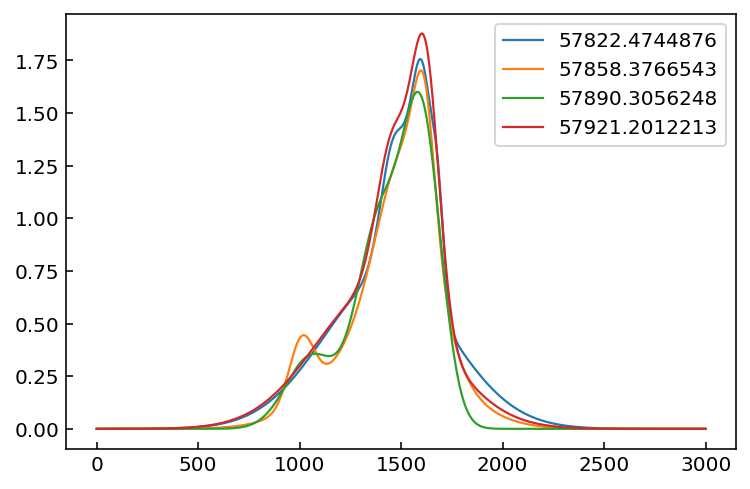

In [196]:

plt.plot(beam_PUPPI_ip.get_profiles()[24],label=beam_PUPPI_ip.get_profiles_epochs()[24])
plt.plot(beam_PUPPI_ip.get_profiles()[25],label=beam_PUPPI_ip.get_profiles_epochs()[25])
plt.plot(1.25*beam_PUPPI_ip.get_profiles()[26],label=beam_PUPPI_ip.get_profiles_epochs()[26])
plt.plot(beam_PUPPI_ip.get_profiles()[27],label=beam_PUPPI_ip.get_profiles_epochs()[27])
plt.legend()
beam_PUPPI_mp.get_profiles_epochs()[15]

#plt.plot(beam_PUPPI_ip.get_profiles()[1])
#plt.plot(beam_PUPPI_ip.get_profiles()[2])
#plt.plot(beam_PUPPI_ip.get_profiles()[5])
#beam_PUPPI_ip.get_profiles_epochs()[5]

In [43]:
print 10**(np.linspace(-0.7,1,num=Nlevels) * np.log10(70))

[  5.11012322e-02   6.55529577e-02   8.40917153e-02   1.07873341e-01
   1.38380549e-01   1.77515373e-01   2.27717753e-01   2.92117657e-01
   3.74730229e-01   4.80706117e-01   6.16652601e-01   7.91045542e-01
   1.01475782e+00   1.30173723e+00   1.66987609e+00   2.14212676e+00
   2.74793266e+00   3.52506399e+00   4.52197258e+00   5.80081272e+00
   7.44131628e+00   9.54576379e+00   1.22453613e+01   1.57084206e+01
   2.01508533e+01   2.58496318e+01   3.31600580e+01   4.25379152e+01
   5.45678849e+01   7.00000000e+01]
